### A Start at some correspondence analysis like I did for Corpus Linguistics

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for fancy interactive plot
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import os # to check if directory exists and create it if it doesn't
from datetime import datetime # to parse speech date
from nrclex import NRCLex
import spacy
import en_core_web_md
import csv
import prince # for correspondence analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text
stopwords = pd.read_table('./word_lists/kaggle_stopwords.txt')
import unicodedata

[Skip to load previously saved contingency table](#loadctab)

In [2]:
# Load the two data sets needed
# string encodings to try utf_8, iso8859_15
facetPlotData = pd.read_csv('facetPlotData.csv')
df = pd.read_csv('fullEmotionData.csv', encoding='utf-8') # apostrophes aren't being read correctly
# Pandas reads date as string, cast to datetime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
facetPlotData['date'] = pd.to_datetime(facetPlotData['date'], format='%Y-%m-%d')
facetPlotData.shape # Should be (3000, 4) 

(3000, 4)

<A HREF="https://regexr.com/">RegExr</A>

In [3]:
#Load SpaCy English Model
nlp = en_core_web_md.load()

In [4]:
punc = '''!()-[]{};:"\,<>./?—â@#$%^&*_~â'''
sources = ['text_oba', 'text_nyt', 'text_wsj']
for source in sources:
    for i in range(len(df[source])):
        nopunc = ''.join([letter if letter not in punc else " " for letter in df[source][i] ])
        df.loc[i, source] =re.sub(' +', ' ', nopunc).replace('\n','').replace("' ", " ").strip()

### <A HREF="https://www.nltk.org/index.html">NLTK Documentation</A> <A HREF="https://www.tomaarsen.com/nltk/api/nltk.html">API reference</A>

In [5]:
# Run this if you want to remove stop words before creating contingency table
kaggle_file = open("./word_lists/kaggle_stopwords.txt", "r")
kaggle_data = kaggle_file.read()
kaggle_list = [word for word in kaggle_data.split('\n')]
kaggle_file.close()
my_list = ['thats', 'just', 'im', 'did', 'thing', 'mr', 'al', 'thank', 'okay', 'thank','thanks', 
           'question', 'joshua', 'president', 'obama', 'â', u'\x99s', u'\x99t', u'\x99ve', u'\x99m',u'\x99re', '\x99']
stop_list = list(set(kaggle_list) | set(my_list))
stop_words = text.ENGLISH_STOP_WORDS.union(stop_list)

for source in sources:
    for i in range(len(df[source])):
        df.loc[i, source] = ' '.join([word for word in df[source][i].split() if word.lower() not in stop_words])

In [6]:
# A little more clean up
nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
for source in sources:
    # lemmatize text with spacy
    #clean out goofy unicode  space characters 
    df[source] = [unicodedata.normalize("NFKD", speech) for speech in df[source] if len(speech)>0 ]
    nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
    for i, doc in enumerate(nlp.pipe(df[source])):
        words_lemmas_list = [token.lemma_ for token in doc]
        df[source][i]= ' '.join(words_lemmas_list)
    print(df[source])

/tmp/ipykernel_39306/833211137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[source][i]= ' '.join(words_lemmas_list)


0     wonderful reception Saint Paul Minnesota JoAnn...
1     hello Chicago doubt America place possible won...
2     right take time come moment know core economic...
3     Barack Hussein solemnly swear execute office U...
4     afternoon evening we be run little bit late ea...
                            ...                        
95    hello America hello Democrats year ago tonight...
96    begin want say outstanding official ground wor...
97    evening let begin thank Xi people Hangzhou Chi...
98    afternoon yesterday vote tally shot video see ...
99    fellow Americans Michelle touch wish receive p...
Name: text_oba, Length: 100, dtype: object
0     Senator Barack claim democratic presidential n...
1     Barack Hussein elect 44th United States Tuesda...
2     elect Barack plan include 300 billion tax cut ...
3     Barack Hussein swear 44th United States Tuesda...
4     debut international stage present leader Ameri...
                            ...                        
95   

In [7]:
# Go through word by word and remove this: â
for source in sources:
    for i in range(len(df[source])):
        df.loc[i, source] = ' '.join([word.replace("â", "") for word in df[source][i].split()])
# Finally, got rid of that stupid thing!

In [8]:
# Create a frequency list of all words in all Obama speeches

# How to flatten a list
#[item for sublist in list_of_lists for item in sublist]

freqlist = nltk.FreqDist([word.lower() for text in df['text_oba'] for word in text.split()])
freqlist

FreqDist({'people': 1118, 'be': 1100, 'work': 831, 'year': 803, 'america': 772, 'know': 714, 'new': 693, 'world': 661, 'country': 632, 'time': 613, ...})

In [9]:
sorted(dict(freqlist).items(),key=lambda x:x[1], reverse=True)[:20]

[('people', 1118),
 ('be', 1100),
 ('work', 831),
 ('year', 803),
 ('america', 772),
 ('know', 714),
 ('new', 693),
 ('world', 661),
 ('country', 632),
 ('time', 613),
 ('job', 568),
 ('american', 560),
 ('want', 527),
 ('right', 518),
 ('come', 518),
 ('help', 504),
 ('nation', 502),
 ('go', 499),
 ('need', 485),
 ('like', 463)]

In [10]:
# list of all the words in the freqlist which is from all 100 documents
words = list(set(dict(freqlist).keys()))
# was getting a weird error below, just making sure all are strings, no numbers
words = [str(word) for word in words] 

### Create Contingency Table - counts of all words in all the documents

In [11]:
# Get counts of all words in 'words' for each speech/article
# I'm doing this the slow way so I can be sure the results are correct.
# I was getting weird numbers using other methods, 
#    like using sklearn countvectorizer I was getting 2900 for 'deepwater' when it should be 4
# I realize this is ugly and slow
counts = []
for i in range(len(df['text_oba'])):
    sums = []
    for word in words:
        summ = 0
        for docword in df['text_oba'][i].split():
            if docword == word:
                summ+=1
        sums.append(summ)
    counts.append(sums)

In [12]:
# Oh man, this is so ugly, just brute force, no style or class. Oh well, it works!
totalcounts = []
for i in range(len(words)):
    summ = 0
    for j in range(len(counts)):
        summ += counts[j][i]
    totalcounts.append(summ)      

In [13]:
# total count of 'deepwater' should be 4 from one speech
word = 'deepwater'
[vectr[words.index(word)] for vectr in counts if vectr[words.index(word)]>0]
# Now with stopwords removed its only 2, wtf????

[2]

In [14]:
# Contingency table
filenames = [name.replace('.txt', '') for name in df['file']]
conttab = pd.DataFrame(counts, columns = words, index = filenames, dtype='int')

In [15]:
conttab.loc['sum',:] = conttab.sum(axis=0)

In [16]:
conttab

,contaminant,policeman,understand,rescue,click,magnetic,founding,tyrant,dynamism,emitter,...,have,ginger,fitter,engage,try,download,step,parisians,satisfy,halt
2008-06-04-ObamaNomination,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2008-11-05-ObamaElected,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2009-01-05-EconomyPlans,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2009-01-20-Inauguration,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2009-04-02-G20Speech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-17-BatonRougeFloods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
2016-09-05-G20Summit,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-11-09-PresidentialElection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2017-01-11-FarewellAddress,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,7.0,0.0,2.0,0.0,0.0,0.0


In [17]:
# And here is the full Contingency Table, sorted with most frequent words first
conttab.sort_values(by='sum', axis=1, ascending=False, inplace=True)
conttab.drop('sum', inplace=True)
conttab

,people,be,work,year,know,new,country,world,time,job,...,soviets,cincinnati,david,dorothy,verizon,francisco,estonians,g20,sandy,gandhi
2008-06-04-ObamaNomination,20.0,2.0,22.0,16.0,8.0,18.0,26.0,6.0,34.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-11-05-ObamaElected,12.0,14.0,5.0,6.0,8.0,10.0,2.0,5.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05-EconomyPlans,6.0,13.0,4.0,5.0,2.0,1.0,0.0,0.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-20-Inauguration,7.0,0.0,8.0,3.0,5.0,11.0,2.0,7.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-04-02-G20Speech,4.0,16.0,2.0,2.0,3.0,2.0,3.0,8.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-28-DemocraticConvention,21.0,13.0,21.0,24.0,35.0,10.0,14.0,8.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-17-BatonRougeFloods,13.0,2.0,6.0,3.0,11.0,1.0,3.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-05-G20Summit,3.0,0.0,4.0,8.0,0.0,3.0,1.0,2.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-09-PresidentialElection,7.0,27.0,10.0,4.0,5.0,0.0,8.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save contingency table, change destination file name

In [18]:
# Save table so we don't have to do this again
#conttab.to_csv('obamaContingencyTable_noSW_new.csv')

<a id='loadctab'>Load Contingency Table</a>

In [19]:
################################ LOAD CONTINGENCY TABLE ###############################
# Read in saved contingency table
ctab = pd.read_csv('obamaContingencyTable_noSW_new.csv',index_col=0)
#ctab = pd.read_csv('GWB_ContingencyTable_noSW.csv',index_col=0)
# Shorten row index names to date only
ctab = ctab.rename(index = lambda x: x[0:10])

In [20]:
# Let's look at the 150 most common words
ctabshort=ctab.iloc[:, : 150]

<A HREF="https://github.com/MaxHalford/prince#correspondence-analysis-ca">Prince Correspondence Analysis</A>

<A HREF="https://pypi.org/project/prince/#history">Prince version history</A>

In [21]:
# Check prince version
#!pip show prince

In [22]:
ca = prince.CA(n_components=2,
               n_iter=3,copy=True,
               check_input=True,
               engine='sklearn',
               random_state=33)

In [23]:
ctabshort.columns.rename('words', inplace=True)
ctabshort.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort)

In [24]:
ca.row_coordinates(ctabshort).head()

,0,1
speeches,,
2008-06-04,-0.202274,-0.275739
2008-11-05,0.059181,0.210844
2009-01-05,0.500941,0.258176
2009-01-20,-0.334240,0.015647
2009-04-02,0.129766,0.411402


In [25]:
ca.column_coordinates(ctabshort).head()

,0,1
words,,
people,-0.250580,0.132549
be,0.880938,0.708518
work,0.016343,-0.162036
year,0.054886,-0.342000
know,0.019507,0.032795


In [26]:
ax = ca.plot(X=ctabshort,
             x_component=0,
             y_component=1,
            )


<A HREF="https://matplotlib.org/cheatsheets/cheatsheets.pdf">Matplotlib basic cheat sheet</A><BR>
    <A HREF="https://matplotlib.org/cheatsheets/">other matplotlib cheat sheets</A>

From NRC analysis the speech with particularly high anger value was 2015-01-08
and particularly high positive value on 2014-03-07

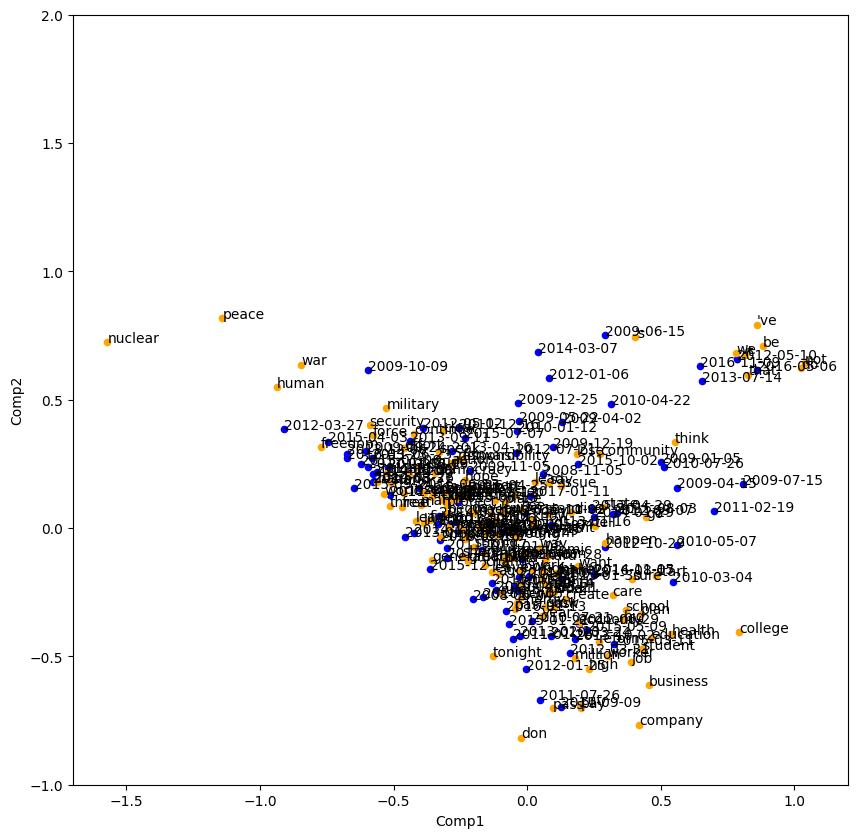

In [27]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

#ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
#ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-1.7, 1.2])
plt.ylim([-1.0, 2.0])
plt.show()

### Try correspondence analysis on a pre-selected list of words

In [ ]:
# Load words from file
# topic words from topic modeling: "./word_lists/topic-words.txt"
# a custom list: "./word_lists/customlist.txt"
# common adjective: "./word_lists/adjectives.txt"
# common adverbs: "./word_lists/adverbs.txt"
# function words: "./word_lists/function-words.txt"
wordList = pd.read_csv("./word_lists/hope_words.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [ ]:
# Make a short contingency list using topic words
ctabshort2 = ctab.loc[ : , [col for col in ctab.columns if col in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort2)[1] > 150:
    ctabshort2=ctabshort2.iloc[:, : 150]
    
ctabshort2.columns.rename('words', inplace=True)
ctabshort2.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort2)

In [ ]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort2)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort2)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

#plt.xlim([-0.5, 1.5])
#plt.ylim([-0.6, 0.4])
plt.show()

### Now try using the most frequent 150 words after removing the Kaggle 700 stop words

In [ ]:
# Load words from file
# Kaggle stop words: "./word_lists/kaggle_stopwords.txt"
wordList = pd.read_csv("./word_lists/kaggle_stopwords.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [ ]:
number_of_words = 400
# Make a short contingency list removing the Kaggle stop words
ctabshort3 = ctab.loc[ : , [col for col in ctab.columns if col not in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort3)[1] > number_of_words:
    ctabshort3=ctabshort3.iloc[:, : number_of_words]
    
ctabshort3.columns.rename('words', inplace=True)
ctabshort3.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort3)

In [ ]:
date1 = '2015-01-08' # date 1 is red X
date2 = '2011-05-02' # date 2 is green pentagon
df1=ca.row_coordinates(ctabshort3)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort3)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches - blue
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words - orange
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

#plt.xlim([0.4, 1.0])
#plt.ylim([-0.25, 0.25])
plt.show()

In [ ]:
# LETS TRY THIS CODE
# https://okomestudio.net/biboroku/2014/05/brand-positioning-by-correspondence-analysis/

In [31]:
#!/usr/bin/env python2.7
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd


class CA(object):
    """Simple corresondence analysis.
    
    Inputs
    ------
    ct : array_like
      Two-way contingency table. If `ct` is a pandas DataFrame object,
      the index and column values are used for plotting.
    Notes
    -----
    The implementation follows that presented in 'Correspondence
    Analysis in R, with Two- and Three-dimensional Graphics: The ca
    Package,' Journal of Statistical Software, May 2007, Volume 20,
    Issue 3.
    """

    def __init__(self, ct):
        self.rows = ct.index.values if hasattr(ct, 'index') else None
        self.cols = ct.columns.values if hasattr(ct, 'columns') else None
        
        # contingency table
        N = np.matrix(ct, dtype=float)

        # correspondence matrix from contingency table
        P = N / N.sum()

        # row and column marginal totals of P as vectors
        r = P.sum(axis=1)
        c = P.sum(axis=0).T

        # diagonal matrices of row/column sums
        D_r_rsq = np.diag(1. / np.sqrt(r.A1))
        D_c_rsq = np.diag(1. / np.sqrt(c.A1))

        # the matrix of standarized residuals
        S = D_r_rsq * (P - r * c.T) * D_c_rsq

        # compute the SVD
        U, D_a, V = svd(S, full_matrices=False)
        D_a = np.asmatrix(np.diag(D_a))
        V = V.T

        # principal coordinates of rows
        F = D_r_rsq * U * D_a

        # principal coordinates of columns
        G = D_c_rsq * V * D_a

        # standard coordinates of rows
        X = D_r_rsq * U

        # standard coordinates of columns
        Y = D_c_rsq * V

        # the total variance of the data matrix
        inertia = sum([(P[i,j] - r[i,0] * c[j,0])**2 / (r[i,0] * c[j,0])
                       for i in range(N.shape[0])
                       for j in range(N.shape[1])])

        self.F = F.A
        self.G = G.A
        self.X = X.A
        self.Y = Y.A
        self.inertia = inertia
        self.eigenvals = np.diag(D_a)**2

    def plot(self):
        """Plot the first and second dimensions."""
        xmin, xmax = None, None
        ymin, ymax = None, None
        if self.rows is not None:
            for i, t in enumerate(self.rows):
                x, y = self.F[i,0], self.F[i,1]
                plt.text(x, y, t, va='center', ha='center', color='r')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.F[:, 0], self.F[:, 1], 'ro')

        if self.cols is not None:
            for i, t in enumerate(self.cols):
                x, y = self.G[i,0], self.G[i,1]
                plt.text(x, y, t, va='center', ha='center', color='b')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.G[:, 0], self.G[:, 1], 'bs')

        if xmin and xmax:
            pad = (xmax - xmin) * 0.1
            plt.xlim(xmin - pad, xmax + pad)
        if ymin and ymax:
            pad = (ymax - ymin) * 0.1
            plt.ylim(ymin - pad, ymax + pad)

        plt.grid()
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')

    def scree_diagram(self, perc=True, *args, **kwargs):
        """Plot the scree diagram."""
        eigenvals = self.eigenvals
        xs = np.arange(1, eigenvals.size + 1, 1)
        ys = 100. * eigenvals / eigenvals.sum() if perc else eigenvals
        plt.plot(xs, ys, *args, **kwargs)
        plt.xlabel('Dimension')
        plt.ylabel('Eigenvalue' + (' [%]' if perc else ''))


/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


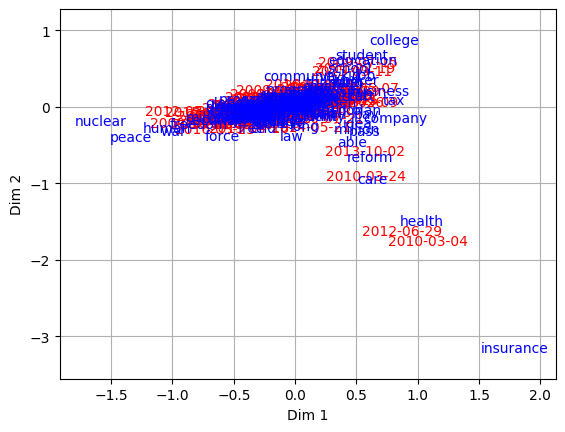

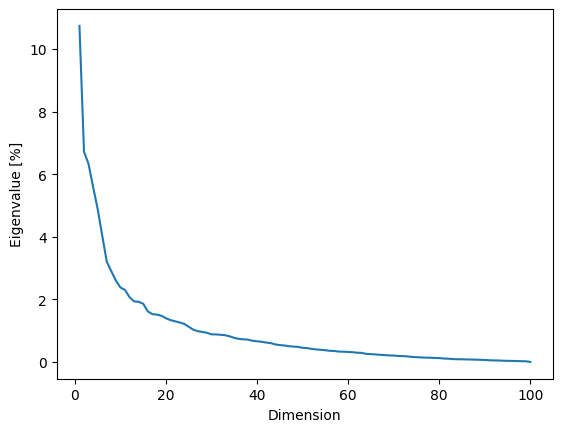

In [32]:
################################ LOAD CONTINGENCY TABLE ###############################
# Read in saved contingency table
ctab = pd.read_csv('obamaContingencyTable_noSW.csv',index_col=0)
# Shorten row index names to date only
ctab = ctab.rename(index = lambda x: x[0:10])
# Let's look at the 150 most common words
ctabshort=ctab.iloc[:, : 150]


df = pd.io.parsers.read_csv('obamaContingencyTable_noSW.csv')
df = df.set_index('speech')

#print(df.describe())
#print( df.head())

ca = CA(ctabshort)

plt.figure(100)
ca.plot()

plt.figure(101)
ca.scree_diagram()

plt.show()